### Import Libraries

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix


### Load Data

In [2]:
# Make DataFrame for Image pathes and their labels
data = pd.DataFrame(columns=["image_path", "label"])

# Define Classes
data_path = os.path.join(os.getcwd(), 'data')
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        label = folder
        data = pd.concat([data, pd.DataFrame({"image_path": [image_path], "label": [label]})], ignore_index=True)

# Get unique labels and their counts
unique_labels = data.label.unique()
label_counts = data.label.value_counts()

classes = unique_labels

### Visualization

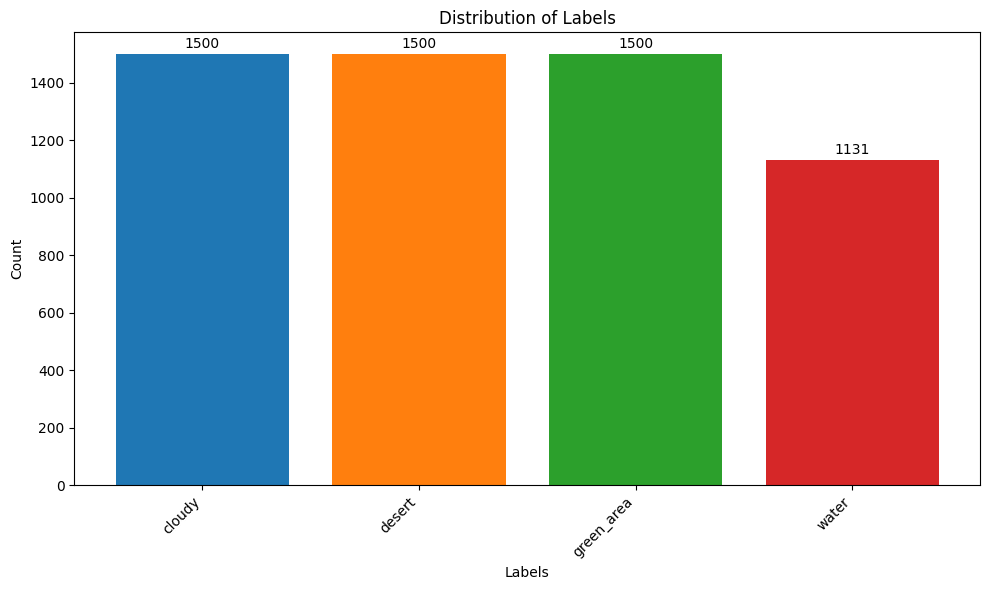

In [3]:
# Define colors for the bar plot
colors = plt.cm.tab10.colors[:len(unique_labels)]

# Plot the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_labels, label_counts, color=colors)
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

# Add annotation on top of each bar
for bar, count in zip(bars, label_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

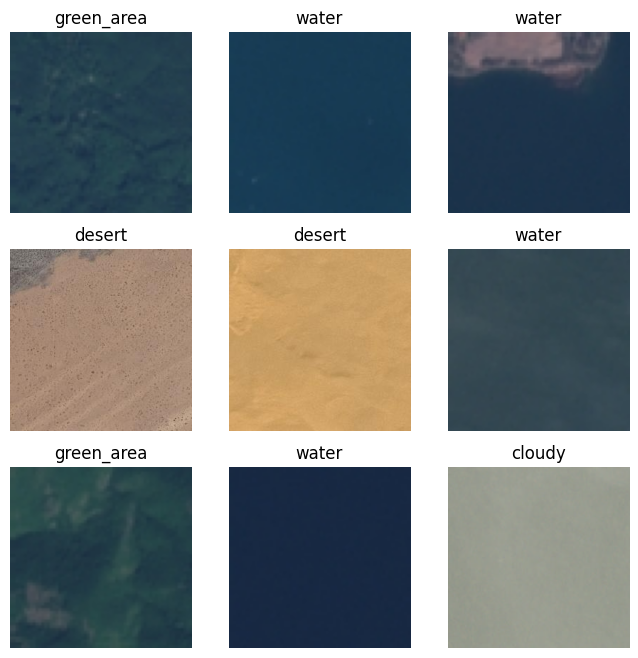

In [4]:
# Show sample images
indices = random.sample(range(5600), 10)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    img = plt.imread(data.iloc[indices[i]].image_path)
    label = data.iloc[indices[i]].label
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.show()

### Models

In [5]:
# Split data into train, validation, and test sets
train_df, val_test_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

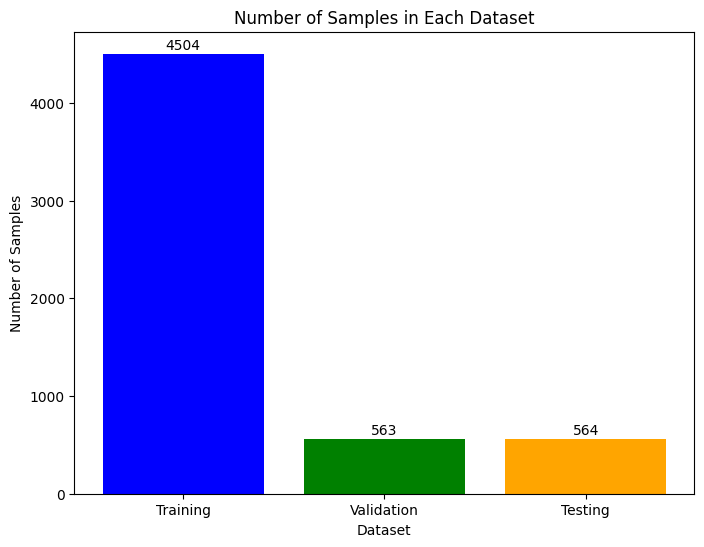

In [6]:
# Get the number of samples for each dataset
num_train_samples = train_df.shape[0]
num_val_samples = val_df.shape[0]
num_test_samples = test_df.shape[0]

# Define labels and values for the bar plot
labels = ['Training', 'Validation', 'Testing']
values = [num_train_samples, num_val_samples, num_test_samples]
colors = ['blue', 'green', 'orange']

# Plot the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)
plt.title('Number of Samples in Each Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')

# Add annotation on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(value), ha='center', va='bottom')

plt.show()

In [7]:
# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data branches
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(64, 64),
                                                    batch_size=32,
                                                    class_mode="categorical")

val_generator = test_datagen.flow_from_dataframe(dataframe=val_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 4504 validated image filenames belonging to 4 classes.
Found 563 validated image filenames belonging to 4 classes.
Found 564 validated image filenames belonging to 4 classes.


### Model Definition and Training

In [8]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from convolutional layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
141/141 [==============================] - 30s 194ms/step - loss: 0.6811 - accuracy: 0.6179 - val_loss: 0.5469 - val_accuracy: 0.6572
Epoch 2/20
141/141 [==============================] - 20s 140ms/step - loss: 0.5794 - accuracy: 0.6734 - val_loss: 0.4640 - val_accuracy: 0.7300
Epoch 3/20
141/141 [==============================] - 21s 146ms/step - loss: 0.5353 - accuracy: 0.7316 - val_loss: 0.4647 - val_accuracy: 0.7353
Epoch 4/20
141/141 [==============================] - 18s 127ms/step - loss: 0.4449 - accuracy: 0.8051 - val_loss: 0.3623 - val_accuracy: 0.8437
Epoch 5/20
141/141 [==============================] - 18s 127ms/step - loss: 0.3873 - accuracy: 0.8526 - val_loss: 0.3268 - val_accuracy: 0.8739
Epoch 6/20
141/141 [==============================] - 18s 128ms/step - loss: 0.3564 - accuracy: 0.8657 - val_loss: 0.3222 - val_accuracy: 0.8757
Epoch 7/20
141/141 [==============================] - 18s 128ms/step - loss: 0.3671 - accuracy: 0.8472 - val_loss: 0.3079 - val_ac

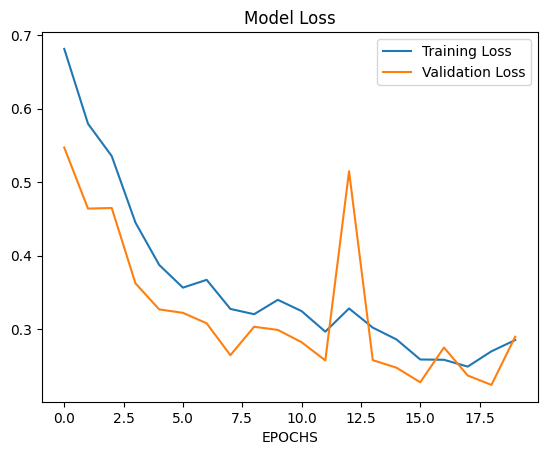

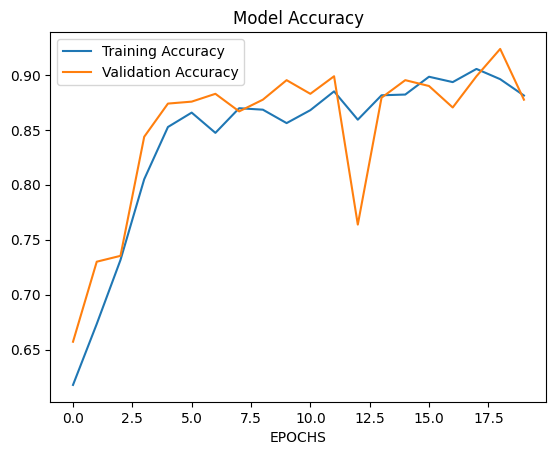

<Figure size 640x480 with 0 Axes>

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("EPOCHS")
plt.title("Model Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("EPOCHS")
plt.title("Model Accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### Model Evaluation

18/18 [==============================] - 1s 54ms/step - loss: 0.3447 - accuracy: 0.8457
Test Loss: 0.3446764349937439
Test Accuracy: 0.8457446694374084
18/18 [==============================] - 1s 38ms/step


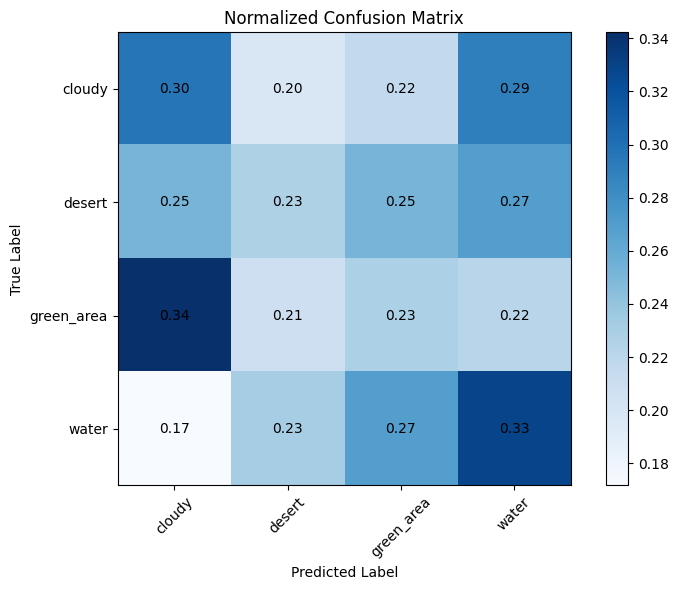

In [13]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Print test loss and test accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if conf_matrix_normalized[i, j] > 0.5 else "black")  # Adjust the threshold as needed

plt.tight_layout()
plt.show()


In [14]:
# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=classes)

# Print classification report
print("Classification Report:")
print(class_report)

# Calculate additional evaluation metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print additional evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Classification Report:
              precision    recall  f1-score   support

      cloudy       0.32      0.30      0.31       162
      desert       0.22      0.23      0.23       119
  green_area       0.25      0.23      0.24       149
       water       0.28      0.33      0.30       134

    accuracy                           0.27       564
   macro avg       0.27      0.27      0.27       564
weighted avg       0.27      0.27      0.27       564

Precision: 0.27133406288280904
Recall: 0.2712765957446808
F1-score: 0.2706414675956163


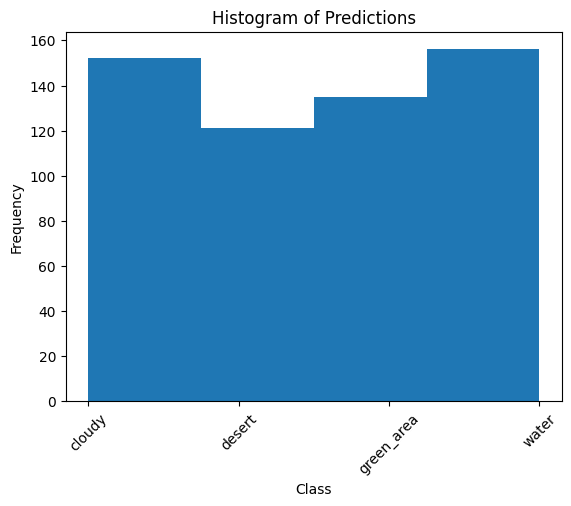

In [15]:
# Histogram of predictions
plt.hist(y_pred, bins=len(classes))
plt.title('Histogram of Predictions')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.show()
